In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Читаем данные из всех листов.

In [230]:
sheets = ["2.85", "3.00", "2.50", "static_2.85", "static_3.00"]
data = {}
for sheet in sheets:
    data[sheet] = pd.read_excel("data.xlsx", engine="openpyxl", sheet_name=sheet)

## Пункт 1

Графики измерений осциллографа

In [231]:
y_delenie = 20    # мВ на деление
x_delenie = 2     # В на деление
R = 100000        # Ом
osc_magnitude = 5 # кофэффициент увеличения, потому что нажата кнопка MAG 5 на осциллографе

In [232]:
Us = {
    "2.50": {"E1": 14 * x_delenie / osc_magnitude, "E2": 29 * x_delenie / osc_magnitude},    # eV
    "2.85": {"E1": 6 * x_delenie / osc_magnitude, "E2": 17 * x_delenie / osc_magnitude},     # eV
    "3.00": {"E1": 5 * x_delenie / osc_magnitude, "E2": 24 * x_delenie / osc_magnitude},     # eV
}
sigma_E = np.float128('0.2')            # eV

In [233]:
# Ток катода, из графика следует, что это ток при E1
I_0 = {}

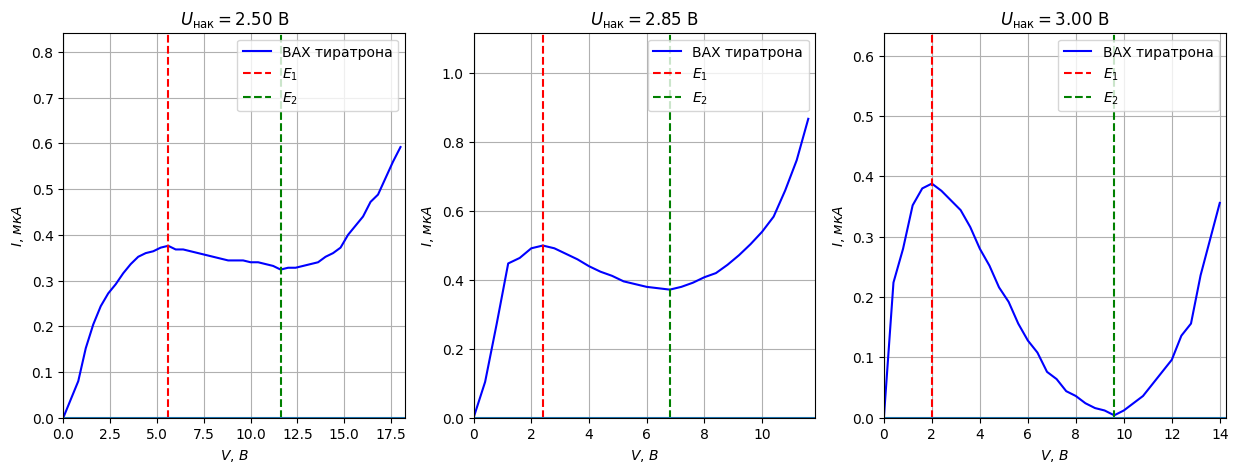

In [234]:
plt.figure(figsize=(15, 5))

U_naks = ["2.50", "2.85", "3.00"]

X = {}
Y = {}


for i in range(len(U_naks)):
    x_0 = -max(data[U_naks[i]]["X, 2 V per delenie"])
    y_0 = min(data[U_naks[i]]["Y, 20 mV per delenie"])
    x = -data[U_naks[i]]["X, 2 V per delenie"] - x_0
    y = data[U_naks[i]]["Y, 20 mV per delenie"] - y_0

    y = y_delenie * y / osc_magnitude / 1000 / R * 1e6 # мкА
    x = x_delenie * x / osc_magnitude                  # В

    Y[U_naks[i]] = y
    X[U_naks[i]] = x

    for j in range(len(x)):
        if x[j] == Us[U_naks[i]]["E1"]:
            I_0[U_naks[i]] = y[j]
    

    plt.subplot(1, 3, i+1)
    U_text = r"U_{\text{нак}}"
    plt.title(f"${U_text} = {U_naks[i]}$ В")
    plt.plot(x, y, "-b", label="ВАХ тиратрона")
    plt.xlabel(r"$V$, $В$")
    plt.ylabel(r"$I$, $мкА$")

    plt.vlines(Us[U_naks[i]]["E1"], 0, max(y)+1, linestyles='--', label="$E_1$", colors="red")
    plt.vlines(Us[U_naks[i]]["E2"], 0, max(y)+1, linestyles='--', label="$E_2$", colors="green")

    plt.grid(True, linestyle="-")
    plt.xlim(0, max(x) + 0.25)
    plt.ylim(0, max(y) + 0.25)
    plt.axhline(0)
    plt.axvline(0)
    plt.legend()

plt.savefig("plots/oscilloscopes_dynamic.pdf")
plt.show()

In [235]:
for U in U_naks:
    print(f"при U_nak = {U}:   I_0 = {I_0[U]:.2f} ")

при U_nak = 2.50:   I_0 = 0.38 
при U_nak = 2.85:   I_0 = 0.50 
при U_nak = 3.00:   I_0 = 0.39 


$$ 2l = \cfrac{h}{\sqrt{2m \left(E_1 + U_0\right)}}, \ \ \ 2l = \cfrac{3}{2} \cfrac{h}{\sqrt{2m \left(E_2 + U_0\right)}} $$


В нашем случае положим $U_0 = 2.5$ В. Если выразить массу в эВ:

$$ 2l = \cfrac{h c}{\sqrt{2m \left(E_1 + U_0\right)}}, \ \ \ 2l = \cfrac{3}{2} \cfrac{hc}{\sqrt{2m \left(E_2 + U_0\right)}} $$

Если исключить $U_0$ (тоже масса в эВ):

$$ l = \cfrac{hc \sqrt{5}}{\sqrt{32 m \left(E_2 - E_1\right)}} $$

Погрешности:

для вычисления через $E_1$ и $U_0$: $$ \sigma_{1,0} = \left| \cfrac{\partial l}{\partial E_1} \right| \sigma_{E_1} = \left| - \cfrac{1}{4} \cfrac{hc \cdot 2m}{\sqrt{8m^3 \left(E_1 + U_0\right)^3}} \right| \sigma_{E_1} = \cfrac{hc\sigma_{E_1}}{4\sqrt{2m\left(E_1 + U_0\right)^3}} = l \cfrac{\sigma_{E_1}}{2(E_1 + U_0)}  $$

для вычисления через $E_2$ и $U_0$: $$ \sigma_{2,0} = \left| \cfrac{\partial l}{\partial E_2} \right| \sigma_{E_2} = \cfrac{3hc\sigma_{E_2}}{8\sqrt{2m\left(E_1 + U_0\right)^3}} = l \cfrac{\sigma_{E_2}}{2(E_2 + U_0)} $$

для вычисления через $E_1$ и $E_2$: $$ \sigma_{1,2} = \sqrt{ \left( \cfrac{\partial l}{\partial E_1} \right)^2 \sigma_{E_1} + \left( \cfrac{\partial l}{\partial E_2} \right)^2 \sigma_{E_2} } = \sqrt{ \left( -\cfrac{1}{2} \cfrac{hc \sqrt{5} \cdot (-32m)}{\sqrt{32^3 m^3 \left(E_2 - E_1\right)^3}} \right)^2 \sigma_{E_1} + \left( -\cfrac{1}{2} \cfrac{hc \sqrt{5} \cdot (32m)}{\sqrt{32^3 m^3 \left(E_2 - E_1\right)^3}} \right)^2 \sigma_{E_2} } =  $$

$$ = \sqrt{ \left( \cfrac{1}{2} \cfrac{hc \sqrt{5}}{\sqrt{32 m \left(E_2 - E_1\right)^3}} \right)^2 \sigma_{E_1} + \left( \cfrac{1}{2} \cfrac{hc \sqrt{5}}{\sqrt{32 m \left(E_2 - E_1\right)^3}} \right)^2 \sigma_{E_2} } = \sqrt{ \left( \cfrac{l}{2(E_2 - E_1)} \right)^2 \sigma_{E_1} + \left( \cfrac{l}{2(E_2 - E_1)} \right)^2 \sigma_{E_2} } = \cfrac{l\sqrt{\sigma_{E_1}^2 + \sigma_{E_2}^2}}{2(E_2 - E_1)} $$

In [236]:
U_0_theor = np.float128('2.5')                          # eV
m = np.float128('511e3')                                # ev
hc = np.float128(6.62607015 * 3e8 / 1.6e-19 * 1e-34)    # eV * m

In [237]:
ls = {}
sigma_ls = {}
for U in Us.keys():
    ls[U] = {}
    sigma_ls[U] = {}
    E1 = Us[U]["E1"]
    E2 = Us[U]["E2"]
    ls[U]["E1"] = 1e10 * 0.5 * hc / np.sqrt(2 * m * (E1 + U_0_theor))                            # A
    sigma_ls[U]["E1"] = ls[U]["E1"] * sigma_E / (E1 + U_0_theor) / 2                             # A

    ls[U]["E2"] = 1e10 * 0.75 * hc / np.sqrt(2 * m * (E2 + U_0_theor))                           # A
    sigma_ls[U]["E2"] = ls[U]["E2"] * sigma_E / (E2 + U_0_theor) / 2                             # A

    ls[U]["E2 - E1"] = 1e10 * np.sqrt(5) * hc / np.sqrt(32 * m * (E2 - E1))                      # A
    sigma_ls[U]["E2 - E1"] = ls[U]["E2 - E1"] * np.sqrt(sigma_E**2 + sigma_E**2) / (E2 - E1) / 2 # A

    print()
    print(f"U_nak = {U}")
    print(f"\t l_E1 =  {ls[U]["E1"]:.2f} +- {sigma_ls[U]["E1"]:.2f} \t A")
    print(f"\t l_E2 =  {ls[U]["E2"]:.2f} +- {sigma_ls[U]["E2"]:.2f} \t A")
    print(f"\t l_ =    {ls[U]["E2 - E1"]:.1f}  +- {sigma_ls[U]["E2 - E1"]:.1f}   \t A")


U_nak = 2.50
	 l_E1 =  2.16 +- 0.03 	 A
	 l_E2 =  2.45 +- 0.02 	 A
	 l_ =    2.8  +- 0.1   	 A

U_nak = 2.85
	 l_E1 =  2.78 +- 0.06 	 A
	 l_E2 =  3.02 +- 0.03 	 A
	 l_ =    3.3  +- 0.1   	 A

U_nak = 3.00
	 l_E1 =  2.90 +- 0.06 	 A
	 l_E2 =  2.65 +- 0.02 	 A
	 l_ =    2.5  +- 0.0   	 A


## Пункт 2

Посчитаем глубину потенциальной ямы: $$ U_0 = \cfrac{4}{5} E_2 - \cfrac{9}{5} E_1 $$

In [238]:
U_0s = {}
for U in Us.keys():
    E1 = Us[U]["E1"]
    E2 = Us[U]["E2"]
    U_0s[U] = 4 * E2 / 5 - 9 * E1 / 5

    print()
    print(f"U_nak = {U} \t V")
    print(f"U_0   = {U_0s[U]:.3f} \t eV")


U_nak = 2.50 	 V
U_0   = -0.800 	 eV

U_nak = 2.85 	 V
U_0   = 1.120 	 eV

U_nak = 3.00 	 V
U_0   = 4.080 	 eV


## Пункт 3

In [239]:
V_proboi = {
    "2.50": np.float128('13'), # V
    "2.85": np.float128('11'), # V
    "3.00": np.float128('12'), # V
}

In [240]:
U_ion = {}
for U in V_proboi.keys():
    U_ion[U] = U_0s[U] + V_proboi[U]
    print(f"U_i = {U_ion[U]:.2f}")

U_i = 12.20
U_i = 12.12
U_i = 16.08


## Пункт 4

In [241]:
E_static = {
    "2.85": {"E1": 2.42, "E2": 7.34},
    "3.00": {"E1": 2.52, "E2": 7.1},
}

In [242]:
def sigmoid(x, x0, b, a):
    return a / (1 + np.exp(-(x - x0))) + b

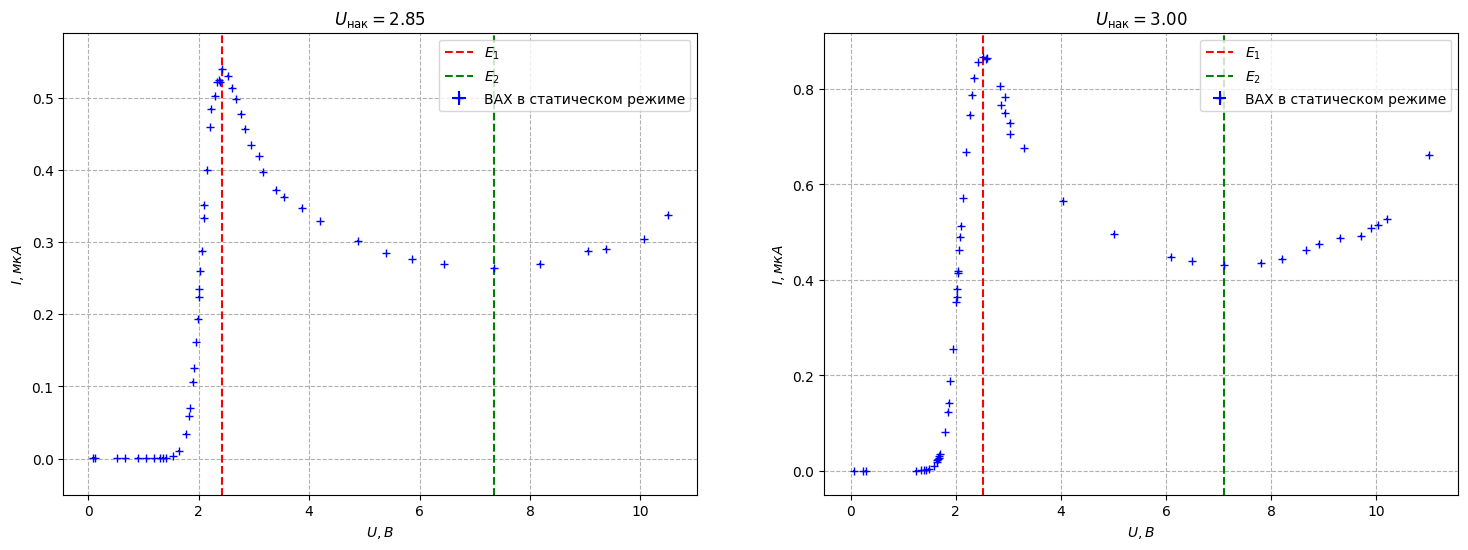

In [243]:
static_Us = ["2.85", "3.00"]
sigma_U = 0.01
sigma_I = 0.0005

plt.figure(figsize=(18, 6))


for i in range(len(static_Us)):
    U_nak = static_Us[i]
    key = f"static_{U_nak}"

    # print(f"U_nak = {U_nak}")
    # print(f"E1 = {data[key]["U, V"].iloc[np.argmax(data[key]["I, мкА"])]}")


    plt.subplot(1, 2, i+1)
    plt.grid(True, linestyle='--')

    plt.title(r"$U_{\text{нак}} = $" + f"{U_nak}")
    plt.errorbar(data[key]["U, V"], data[key]["I, мкА"], xerr=sigma_U, yerr=sigma_I, fmt="+b", label="ВАХ в статическом режиме")

    X[key] = data[key]["U, V"]
    Y[key] = data[key]["I, мкА"]

    plt.vlines(E_static[U_nak]["E1"], -1, max(data[key]["I, мкА"]) + 0.05, linestyles='--', colors="red", label="$E_1$")
    plt.vlines(E_static[U_nak]["E2"], -1, max(data[key]["I, мкА"]) + 0.05, linestyles='--', colors="green", label="$E_2$")

    plt.ylim(-0.05, max(data[key]["I, мкА"]) + 0.05)



    x_model = np.linspace(min(data[key]["U, V"]), max(data[key]["U, V"]), 1000)


    plt.xlabel(r"$U, В$")
    plt.ylabel(r"$I, мкА$")

    plt.legend()

plt.savefig("plots/static_vah.pdf")
plt.show()

In [244]:
I_0["static_2.85"] = max(Y["static_2.85"])
I_0["static_3.00"] = max(Y["static_3.00"])

In [245]:
for U in static_Us:
    key = f"static_{U}"
    print(f"при U_nak = {U}:   I_0 = {I_0[key]:.2f} ")

при U_nak = 2.85:   I_0 = 0.54 
при U_nak = 3.00:   I_0 = 0.87 


In [246]:
ls_static = {}
sigma_ls_static = {}
for U in static_Us:
    ls_static[U] = {}
    sigma_ls_static[U] = {}
    E1 = E_static[U]["E1"]
    E2 = E_static[U]["E2"]
    ls_static[U]["E1"] = 1e10 * 0.5 * hc / np.sqrt(2 * m * (E1 + U_0_theor))                            # A
    sigma_ls_static[U]["E1"] = ls_static[U]["E1"] * sigma_E / (E1 + U_0_theor) / 2                             # A

    ls_static[U]["E2"] = 1e10 * 0.75 * hc / np.sqrt(2 * m * (E2 + U_0_theor))                           # A
    sigma_ls_static[U]["E2"] = ls_static[U]["E2"] * sigma_E / (E2 + U_0_theor) / 2                             # A

    ls_static[U]["E2 - E1"] = 1e10 * np.sqrt(5) * hc / np.sqrt(32 * m * (E2 - E1))                      # A
    sigma_ls_static[U]["E2 - E1"] = ls_static[U]["E2 - E1"] * np.sqrt(sigma_E**2 + sigma_E**2) / (E2 - E1) / 2 # A

    print()
    print(f"U_nak = {U}")
    print(f"\t l_E1 = {ls_static[U]["E1"]:.2f} +- {sigma_ls_static[U]["E1"]:.2f} \t A")
    print(f"\t l_E2 = {ls_static[U]["E2"]:.2f} +- {sigma_ls_static[U]["E2"]:.2f} \t A")
    print(f"\t l_   = {ls_static[U]["E2 - E1"]:.1f}  +- {sigma_ls_static[U]["E2 - E1"]:.1f}   \t A")


U_nak = 2.85
	 l_E1 = 2.77 +- 0.06 	 A
	 l_E2 = 2.94 +- 0.03 	 A
	 l_   = 3.1  +- 0.1   	 A

U_nak = 3.00
	 l_E1 = 2.74 +- 0.05 	 A
	 l_E2 = 2.97 +- 0.03 	 A
	 l_   = 3.2  +- 0.1   	 A


In [247]:
U_0s_static = {}
for U in static_Us:
    E1 = E_static[U]["E1"]
    E2 = E_static[U]["E2"]
    U_0s_static[U] = 4 * E2 / 5 - 9 * E1 / 5

    print()
    print(f"U_nak = {U} \t V")
    print(f"U_0   = {U_0s_static[U]:.3f} \t eV")

U_0 = np.mean([U_0s_static[U] for U in static_Us])
print()
print(f"Итоговое")
print(f"U_0 = {U_0} eV")


U_nak = 2.85 	 V
U_0   = 1.516 	 eV

U_nak = 3.00 	 V
U_0   = 1.144 	 eV

Итоговое
U_0 = 1.33 eV


In [248]:
V_proboi_static = {
    "2.85": max(data["static_2.85"]["U, V"]), # V
    "3.00": max(data["static_3.00"]["U, V"]), # V
}

In [249]:
U_ion_static = {}
for U in static_Us:
    U_ion_static[U] = U_0s_static[U] + V_proboi_static[U]
    print(f"U_i = {U_ion_static[U]}")

U_i = np.mean([U_ion_static[U] for U in static_Us])
print()
print("Итоговое")
print(f"U_i = {U_i}")

U_i = 12.016
U_i = 12.144

Итоговое
U_i = 12.08


## Пункт 5

$$ \sqrt{\cfrac{2m \left( E_n + U_0 \right)}{\hbar^2}} l = n \pi, \ \ \  \sqrt{\cfrac{2m \left( E_1 + U_0 \right)}{\hbar^2}} l = \pi \implies $$

$$ \implies \cfrac{E_n + U_0}{E_1 + U_0} = n^2 \implies E_n = n^2 \left(E_1 + U_0\right) - U_0 $$

In [250]:
def E(E1, n, U0):
    return n**2 * (E1 + U0) - U0

In [251]:
ns = np.arange(3) + 1

Es = {}
for U in E_static.keys():
    Es[U] = E(E_static[U]["E1"], ns, U_0)
    print("-" * 40)
    print(f"U_nak = {U}")
    print(f"\t E1 \t E2 \t E3")
    print(f"exp \t {E_static[U]["E1"]:.2f} \t {E_static[U]["E2"]:.2f}")
    print(f"pred \t {Es[U][0]:.2f} \t {Es[U][1]:.2f} \t {Es[U][2]:.2f}")

----------------------------------------
U_nak = 2.85
	 E1 	 E2 	 E3
exp 	 2.42 	 7.34
pred 	 2.42 	 13.67 	 32.42
----------------------------------------
U_nak = 3.00
	 E1 	 E2 	 E3
exp 	 2.52 	 7.10
pred 	 2.52 	 14.07 	 33.32


## Пункт 6

$$ w(V) = - \cfrac{1}{C} \ln {\cfrac{I_a(V)}{I_0}} $$

In [252]:
def omega(x, a):
    return (- 1 / a) * np.log(x)

/home/lev/Documents/gitrepos/Lab_MIPT/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


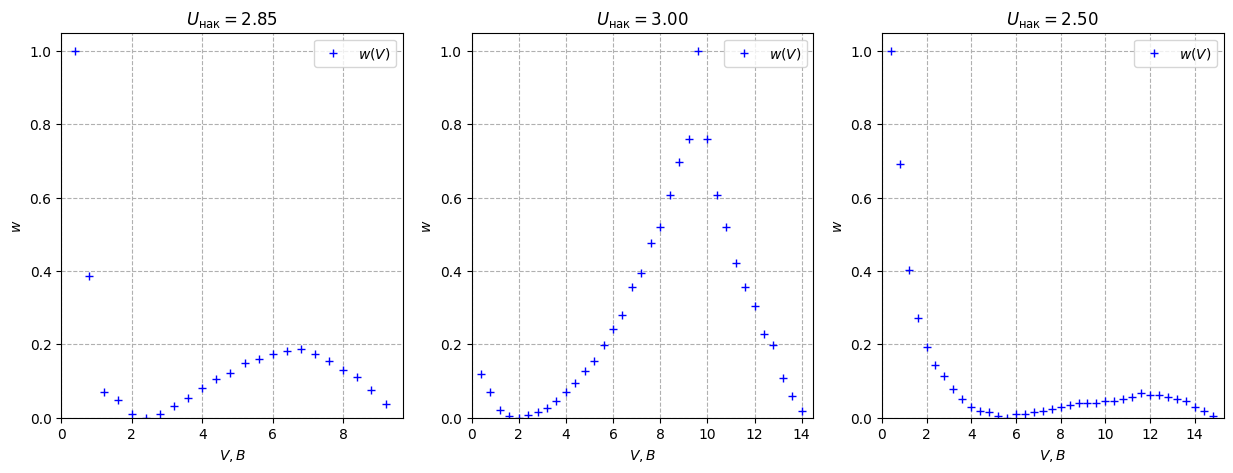

In [256]:
plt.figure(figsize=(15, 5))

for i in range(len(Us)):
    U = sheets[i]
    x = X[U]
    y = -np.log(Y[U] / I_0[U])

    mask = np.isfinite(y) & (y >= 0)

    w = y[mask]
    x = x[mask]
    w /= max(w)
    
    tmp = sorted(list(zip(x, w)), key=(lambda x: x[0]))
    x = []
    w = []
    for x_, w_ in tmp:
        x.append(x_)
        w.append(w_)
    x = np.array(x)
    w = np.array(w)

    plt.subplot(1, 3, i+1)
    plt.ylim(0, max(w)+0.05)
    plt.xlim(0, max(x) + 0.5)

    plt.grid(True, linestyle='--')
    plt.xlabel(r"$V, В$")
    plt.ylabel("$w$")
    plt.title(r"$U_{\text{нак}} = " + U + '$' if 'static' not in U else r"$U_{\text{нак}} = " + U[-4:] + '$')

    plt.plot(x, w, '+b', label=rf"$w(V)$")
    plt.legend()

plt.savefig("plots/w_dynamic.pdf")
plt.show()

/home/lev/Documents/gitrepos/Lab_MIPT/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


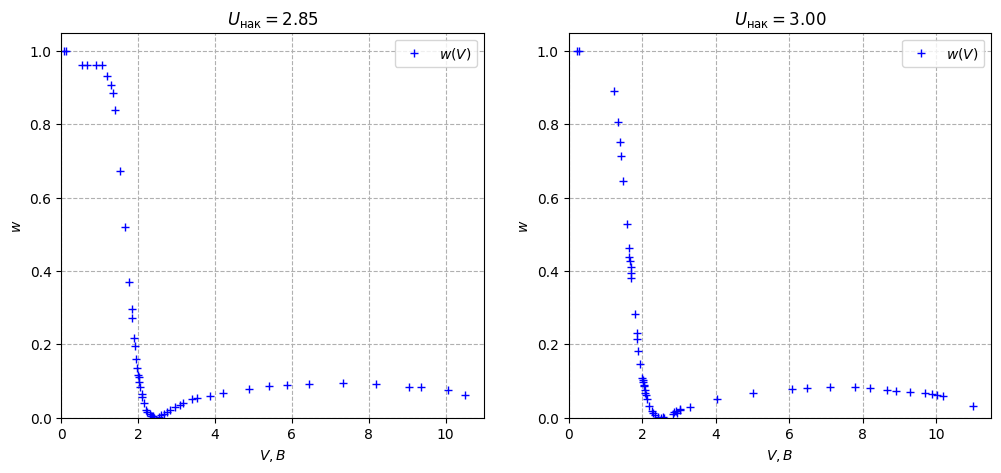

In [255]:
plt.figure(figsize=(12, 5))

for i in range(len(static_Us)):
    U = f"static_{static_Us[i]}"
    x = X[U]
    y = -np.log(Y[U] / I_0[U])

    mask = np.isfinite(y) & (y >= 0)

    w = y[mask]
    x = x[mask]
    w /= max(w)
    
    tmp = sorted(list(zip(x, w)), key=(lambda x: x[0]))
    x = []
    w = []
    for x_, w_ in tmp:
        x.append(x_)
        w.append(w_)
    x = np.array(x)
    w = np.array(w)

    plt.subplot(1, 2, i+1)
    plt.ylim(0, max(w)+0.05)
    plt.xlim(0, max(x) + 0.5)

    plt.grid(True, linestyle='--')
    plt.xlabel(r"$V, В$")
    plt.ylabel("$w$")
    plt.title(r"$U_{\text{нак}} = " + U + '$' if 'static' not in U else r"$U_{\text{нак}} = " + U[-4:] + '$')

    plt.plot(x, w, '+b', label=rf"$w(V)$")
    plt.legend()

plt.savefig("plots/w_static.pdf")
plt.show()